# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [0]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
'My Drive'


KeyboardInterrupt: ignored

# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- Done-train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- Done-The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- Done-voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- Done-ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    data_np = np.zeros(len(data),dtype = np.int64)
    # TODO Add more preprocessing
    
    voc2ind = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26,
                'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52,
                '!': 53, '.': 54, '?': 55, '\'':56, '\"': 57, ',': 58, '-': 59, ':': 60, ';': 61, '0': 62, '1': 63, '2': 64, '3': 65, '4': 66, '5': 67, '6': 68, '7': 69, '8': 70, '9': 71, '10': 72,}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index_data_np = 0
    for char in data:
        if char in voc2ind:
          data_np[index_data_np] = voc2ind[char]
        else:
          data_np[index_data_np] = voc2ind[' ']
        index_data_np = index_data_np + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    len_data = data_np.shape[0]
    len_train = np.floor(len_data * 0.8).astype(np.int32)

    train_text = data_np[0 : len_train] # TODO Fill this in
    test_text = data_np[len_train : -1] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        
        dataset_token = dataset['tokens']
        self.needed_len = int(dataset_token.shape[0] - dataset_token.shape[0] % batch_size)
        self.chunk_len = self.needed_len / self.batch_size
        self.dataset_right = dataset_token[0 : self.needed_len].copy()

        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return np.ceil(self.needed_len / self.batch_size / self.sequence_length).astype(np.int32) * self.batch_size
        
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_index = int(idx % self.batch_size * self.chunk_len)
        sequence_index = int(self.sequence_length * np.floor(idx / self.batch_size))
        begin_index = int(chunk_index + sequence_index)
        end_index = int(begin_index + self.sequence_length + 1)
        if(sequence_index + self.sequence_length + 1 > self.chunk_len):
          end_index = int(begin_index -sequence_index + self.chunk_len)
        data = self.dataset_right[begin_index : end_index] 
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        #print('input_Size', x.size())
        x = self.encoder(x)
        #print('encoder_size', x.size())
        out_gru = self.gru(x, hidden_state)
        #print('gru_0_size', out_gru[0].size())
        x = self.decoder(out_gru[0])
        #print('ou_size', x.size())

        return x, out_gru[1]

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.argmax(output)
        outputs.append(int(voc_arg))
        output, hidden = model.inference(voc_arg, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.multinomial(output, 1)
        outputs.append(voc_arg[0])
        output, hidden = model.inference(voc_arg[0], hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 1)]
    beam_tmp = []
    # TODO
    for i in range(sequence_length):
      for j in range(len(beam)):
        item_of_beam = beam[j]
        value_out_sorted, incide_out_sorted = torch.sort(item_of_beam[1], descending = True)
        for k in range(beam_width):
          output, hidden = model.inference(incide_out_sorted[0,k], item_of_beam[2])
          beam_tmp.append((item_of_beam[0] + [incide_out_sorted[0,k]], output, hidden, item_of_beam[3] * (value_out_sorted[0,k]).cpu().numpy()))
      beam_tmp.sort(key = lambda x : x[3], reverse = True)
      beam = beam_tmp[0:10].copy()
      beam_tmp = []
    
    beam.sort(key = lambda x : x[3], reverse = True)
    outputs = beam[0][0]  
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [0]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 1000
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': 0,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):

            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_perlexity.append((epoch, np.exp(train_loss)))
            test_losses.append((epoch, test_loss))
            test_perlexity.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch, 3)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        #model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 3)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perlexity)
        pt_util.plot(ep, val, 'Train perlexity', 'Epoch', 'Perlexity')
        ep, val = zip(*test_perlexity)
        pt_util.plot(ep, val, 'Test perlexity', 'Epoch', 'Perlexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter is the successor of'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# Part 8.1
1.Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
Options include other books, websites, tweets, wikipedia articles etc.
(Hint: this is probably the easiest one)

Corpus: Leagues under the sea

# The new corpus needs to be uploaded manually!

In [0]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(DATA_PATH):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content

os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    data_np = np.zeros(len(data),dtype = np.int64)
    # TODO Add more preprocessing
    
    voc2ind = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26,
                'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52,
                '!': 53, '.': 54, '?': 55, '\'':56, '\"': 57, ',': 58, '-': 59, ':': 60, ';': 61, '0': 62, '1': 63, '2': 64, '3': 65, '4': 66, '5': 67, '6': 68, '7': 69, '8': 70, '9': 71, '10': 72,}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index_data_np = 0
    for char in data:
        if char in voc2ind:
          data_np[index_data_np] = voc2ind[char]
        else:
          data_np[index_data_np] = voc2ind[' ']
        index_data_np = index_data_np + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    len_data = data_np.shape[0]
    len_train = np.floor(len_data * 0.8).astype(np.int32)

    train_text = data_np[0 : len_train] # TODO Fill this in
    test_text = data_np[len_train : -1] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Leagues_under_the_sea_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Leagues_under_the_sea_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'Leagues_under_the_sea.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [0]:
class LeagueUnderTheSeaDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(LeagueUnderTheSeaDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        
        dataset_token = dataset['tokens']
        self.needed_len = int(dataset_token.shape[0] - dataset_token.shape[0] % batch_size)
        self.chunk_len = self.needed_len / self.batch_size
        self.dataset_right = dataset_token[0 : self.needed_len].copy()

        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return np.ceil(self.needed_len / self.batch_size / self.sequence_length).astype(np.int32) * self.batch_size
        
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_index = int(idx % self.batch_size * self.chunk_len)
        sequence_index = int(self.sequence_length * np.floor(idx / self.batch_size))
        begin_index = int(chunk_index + sequence_index)
        end_index = int(begin_index + self.sequence_length + 1)
        if(sequence_index + self.sequence_length + 1 > self.chunk_len):
          end_index = int(begin_index -sequence_index + self.chunk_len)
        data = self.dataset_right[begin_index : end_index] 
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

In [0]:
TEMPERATURE = 0.5

class LeageUnderTheSeaNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LeageUnderTheSeaNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        #print('input_Size', x.size())
        x = self.encoder(x)
        #print('encoder_size', x.size())
        out_gru = self.gru(x, hidden_state)
        #print('gru_0_size', out_gru[0].size())
        x = self.decoder(out_gru[0])
        #print('ou_size', x.size())

        return x, out_gru[1]

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.argmax(output)
        outputs.append(int(voc_arg))
        output, hidden = model.inference(voc_arg, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.multinomial(output, 1)
        outputs.append(voc_arg[0])
        output, hidden = model.inference(voc_arg[0], hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 1)]
    beam_tmp = []
    # TODO
    for i in range(sequence_length):
      for j in range(len(beam)):
        item_of_beam = beam[j]
        value_out_sorted, incide_out_sorted = torch.sort(item_of_beam[1], descending = True)
        for k in range(beam_width):
          output, hidden = model.inference(incide_out_sorted[0,k], item_of_beam[2])
          beam_tmp.append((item_of_beam[0] + [incide_out_sorted[0,k]], output, hidden, item_of_beam[3] * (value_out_sorted[0,k]).cpu().numpy()))
      beam_tmp.sort(key = lambda x : x[3], reverse = True)
      beam = beam_tmp[0:10].copy()
      beam_tmp = []
    
    beam.sort(key = lambda x : x[3], reverse = True)
    outputs = beam[0][0]  
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [0]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_sea.pkl'


    data_train = LeagueUnderTheSeaDataset(DATA_PATH + 'Leagues_under_the_sea_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = LeagueUnderTheSeaDataset(DATA_PATH + 'Leagues_under_the_sea_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': 0,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LeageUnderTheSeaNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_sea')

    train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):

            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_perlexity.append((epoch, np.exp(train_loss)))
            test_losses.append((epoch, test_loss))
            test_perlexity.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_sea/%03d.pt' % epoch, 3)
            seed_words = 'Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_sea/%03d.pt' % epoch, 3)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perlexity)
        pt_util.plot(ep, val, 'Train perlexity', 'Epoch', 'Perlexity')
        ep, val = zip(*test_perlexity)
        pt_util.plot(ep, val, 'Test perlexity', 'Epoch', 'Perlexity')
        return model, vocab, device

final_model, vocab, device = main()

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'The missing vessel and Captain Nemo '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

# Part 8.2
2.Find a better network architecture. Some ideas:
Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
You can make the network wider or deeper.
You can try to learn separate encoders and decoders.

In [0]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    data_np = np.zeros(len(data),dtype = np.int64)
    # TODO Add more preprocessing
    
    voc2ind = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26,
                'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52,
                '!': 53, '.': 54, '?': 55, '\'':56, '\"': 57, ',': 58, '-': 59, ':': 60, ';': 61, '0': 62, '1': 63, '2': 64, '3': 65, '4': 66, '5': 67, '6': 68, '7': 69, '8': 70, '9': 71, '10': 72,}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index_data_np = 0
    for char in data:
        if char in voc2ind:
          data_np[index_data_np] = voc2ind[char]
        else:
          data_np[index_data_np] = voc2ind[' ']
        index_data_np = index_data_np + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    len_data = data_np.shape[0]
    len_train = np.floor(len_data * 0.8).astype(np.int32)

    train_text = data_np[0 : len_train] # TODO Fill this in
    test_text = data_np[len_train : -1] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        
        dataset_token = dataset['tokens']
        self.needed_len = int(dataset_token.shape[0] - dataset_token.shape[0] % batch_size)
        self.chunk_len = self.needed_len / self.batch_size
        self.dataset_right = dataset_token[0 : self.needed_len].copy()

        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return np.ceil(self.needed_len / self.batch_size / self.sequence_length).astype(np.int32) * self.batch_size
        
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_index = int(idx % self.batch_size * self.chunk_len)
        sequence_index = int(self.sequence_length * np.floor(idx / self.batch_size))
        begin_index = int(chunk_index + sequence_index)
        end_index = int(begin_index + self.sequence_length + 1)
        if(sequence_index + self.sequence_length + 1 > self.chunk_len):
          end_index = int(begin_index -sequence_index + self.chunk_len)
        data = self.dataset_right[begin_index : end_index] 
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 8.2.1 Define the network

In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        
        self.gru = nn.GRU(input_size = self.feature_size, hidden_size = 1000, num_layers = 2, batch_first=True)
        
        self.decoder = nn.Linear(1000, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        #self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        out_gru = self.gru(x, hidden_state)
        x = self.decoder(out_gru[0])
        return x, out_gru[1]

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.argmax(output)
        outputs.append(int(voc_arg))
        output, hidden = model.inference(voc_arg, hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.multinomial(output, 1)
        outputs.append(voc_arg[0])
        output, hidden = model.inference(voc_arg[0], hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 1)]
    beam_tmp = []
    # TODO
    for i in range(sequence_length):
      for j in range(len(beam)):
        item_of_beam = beam[j]
        value_out_sorted, incide_out_sorted = torch.sort(item_of_beam[1], descending = True)
        for k in range(beam_width):
          output, hidden = model.inference(incide_out_sorted[0,k], item_of_beam[2])
          beam_tmp.append((item_of_beam[0] + [incide_out_sorted[0,k]], output, hidden, item_of_beam[3] * (value_out_sorted[0,k]).cpu().numpy()))
      beam_tmp.sort(key = lambda x : x[3], reverse = True)
      beam = beam_tmp[0:10].copy()
      beam_tmp = []
    
    beam.sort(key = lambda x : x[3], reverse = True)
    outputs = beam[0][0]  
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [0]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.00002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_2l.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': 0,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_2l')

    train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):

            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_perlexity.append((epoch, np.exp(train_loss)))
            test_losses.append((epoch, test_loss))
            test_perlexity.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_2l/%03d.pt' % epoch, 3)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_2l/%03d.pt' % epoch, 3)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perlexity)
        pt_util.plot(ep, val, 'Train perlexity', 'Epoch', 'Perlexity')
        ep, val = zip(*test_perlexity)
        pt_util.plot(ep, val, 'Test perlexity', 'Epoch', 'Perlexity')
        return model, vocab, device

final_model, vocab, device = main()

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter is the successor of'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

# Part 8.3
Use an LSTM instead of a GRU.
https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
The output of an LSTM is a hidden state and a cell state, so you will need to deal with a tuple instead of a single vector.

# The new corpus needs to be uploaded manually!

In [125]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [138]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
'My Drive'


In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'
if not os.path.exists(DATA_PATH):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content

os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    data_np = np.zeros(len(data),dtype = np.int64)
    # TODO Add more preprocessing
    
    voc2ind = {' ': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26,
                'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52,
                '!': 53, '.': 54, '?': 55, '\'':56, '\"': 57, ',': 58, '-': 59, ':': 60, ';': 61, '0': 62, '1': 63, '2': 64, '3': 65, '4': 66, '5': 67, '6': 68, '7': 69, '8': 70, '9': 71, '10': 72,}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    index_data_np = 0
    for char in data:
        if char in voc2ind:
          data_np[index_data_np] = voc2ind[char]
        else:
          data_np[index_data_np] = voc2ind[' ']
        index_data_np = index_data_np + 1

    ind2voc = {val: key for key, val in voc2ind.items()}

    len_data = data_np.shape[0]
    len_train = np.floor(len_data * 0.8).astype(np.int32)

    train_text = data_np[0 : len_train] # TODO Fill this in
    test_text = data_np[len_train : -1] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Leagues_under_the_sea_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Leagues_under_the_sea_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'Leagues_under_the_sea.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [0]:
class LeagueUnderTheSeaDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(LeagueUnderTheSeaDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
        
        dataset_token = dataset['tokens']
        self.needed_len = int(dataset_token.shape[0] - dataset_token.shape[0] % batch_size)
        self.chunk_len = self.needed_len / self.batch_size
        self.dataset_right = dataset_token[0 : self.needed_len].copy()

        # TODO: Any preprocessing on the data to get it to the right shape.


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return np.ceil(self.needed_len / self.batch_size / self.sequence_length).astype(np.int32) * self.batch_size
        
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        chunk_index = int(idx % self.batch_size * self.chunk_len)
        sequence_index = int(self.sequence_length * np.floor(idx / self.batch_size))
        begin_index = int(chunk_index + sequence_index)
        end_index = int(begin_index + self.sequence_length + 1)
        if(sequence_index + self.sequence_length + 1 > self.chunk_len):
          end_index = int(begin_index -sequence_index + self.chunk_len)
        data = self.dataset_right[begin_index : end_index] 
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Define the network

In [0]:
TEMPERATURE = 0.5

class LeageUnderTheSeaNet(nn.Module):
    def __init__(self, vocab_size, feature_size, device):
        super(LeageUnderTheSeaNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        self.device = device
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state = None, cell_state = None):
        if(not isinstance(hidden_state, torch.Tensor)):
          hidden_state = torch.zeros([1, x.size()[0], 512], dtype = torch.float64, device = self.device)
          cell_state = torch.zeros([1, x.size()[0], 512], dtype = torch.float64, device = self.device)
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        out_lstm = self.lstm(x,(hidden_state, cell_state))
        x = self.decoder(out_lstm[0])

        return x, out_lstm[1][0], out_lstm[1][1]

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, cell_state = None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state, cell_state = self.forward(x, hidden_state, cell_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state, cell_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, cell, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.argmax(output)
        outputs.append(int(voc_arg))
        output, hidden, cell = model.inference(voc_arg, hidden, cell)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, cell, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        voc_arg = torch.multinomial(output, 1)
        outputs.append(voc_arg[0])
        output, hidden, cell = model.inference(voc_arg[0], hidden, cell)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell, vocab):
    outputs = []
    beam = [([], output, hidden, 1, cell)]
    beam_tmp = []
    # TODO
    for i in range(sequence_length):
      for j in range(len(beam)):
        item_of_beam = beam[j]
        value_out_sorted, incide_out_sorted = torch.sort(item_of_beam[1], descending = True)
        for k in range(beam_width):
          output, hidden, cell = model.inference(incide_out_sorted[0,k], item_of_beam[2], item_of_beam[4])
          beam_tmp.append((item_of_beam[0] + [incide_out_sorted[0,k]], output, hidden, item_of_beam[3] * (value_out_sorted[0,k]).cpu().numpy(), cell))
      beam_tmp.sort(key = lambda x : x[3], reverse = True)
      beam = beam_tmp[0:10].copy()
      beam_tmp = []
    
    beam.sort(key = lambda x : x[3], reverse = True)
    outputs = beam[0][0]  
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        cell = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden, cell = model.inference(data, hidden, cell)
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, cell, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, cell, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, cell, vocab)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def repackage_cell(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    cell = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        if cell is not None:
            cell = repackage_cell(cell)
        optimizer.zero_grad()
        output, hidden, cell = model(data, hidden, cell)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        cell = None
        print('pass1')
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden, cell = model(data, hidden, cell)
            print('pass2')
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([73, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([73, 512]) = 0MB
decoder.bias -> 	torch.Size([73]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints_sea_lstm/000.pt
pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	it dafhh  ns and ah   a meade ahich ta txessofer  b taaa ncnan     Tstuereer tf t daeur anter  aanse


pass2
pass2
pass2
pass2


  0%|          | 0/20 [00:00<?, ?it/s]


Test set: Average loss: 1.9301, Accuracy: 55566/128000 (43%)



  5%|▌         | 1/20 [00:00<00:03,  4.96it/s]

Train Epoch: 0 [0/5120 (0%)]	Loss: 1.850348


 55%|█████▌    | 11/20 [00:02<00:01,  4.88it/s]

Train Epoch: 0 [2560/5120 (50%)]	Loss: 1.849143


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	it dtfhh  n, and th n t teade ahich aa txeseofer  ngta a n nam     Tstuerted tf t dteur tnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.8554, Accuracy: 57467/128000 (45%)

Saved /content/checkpoints_sea_lstm/000.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the said not the surface of the said not the surface of the said not the surface of the said not the surface of the said not the surface of the said not the surface of the said not the surface of t
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the of the of the



  5%|▌         | 1/20 [00:00<00:04,  4.12it/s]

Train Epoch: 1 [0/5120 (0%)]	Loss: 1.761774


 55%|█████▌    | 11/20 [00:02<00:01,  4.78it/s]

Train Epoch: 1 [2560/5120 (50%)]	Loss: 1.695968


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	it dafhh  n  and ah n t seak  ahich aa txessofer  neaaaaan nat     Tssuertid tf t daarr tnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.7644, Accuracy: 60534/128000 (47%)

Saved /content/checkpoints_sea_lstm/001.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the surface of the Nautilus of the surface of the Nautilus of the surface of the Nautilus of the surface of the Nautilus of the surface of the Nautilus of the surface of the Nautilu



 10%|█         | 2/20 [00:00<00:03,  4.90it/s]

Train Epoch: 2 [0/5120 (0%)]	Loss: 1.676960


 55%|█████▌    | 11/20 [00:02<00:01,  4.78it/s]

Train Epoch: 2 [2560/5120 (50%)]	Loss: 1.622465


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	it dafhhm n  and ah k a seaki ahich ha hxes ofer  n aa aan n t     Issuerter tf t  aaurstnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.7239, Accuracy: 61551/128000 (48%)

Saved /content/checkpoints_sea_lstm/002.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the sea was the surface of the sea was the surface of the sea was the surface of the sea was the surface of the sea was the surface of the sea was the surface of the sea was the surface of the sea 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the



 10%|█         | 2/20 [00:00<00:03,  4.96it/s]

Train Epoch: 3 [0/5120 (0%)]	Loss: 1.641236


 55%|█████▌    | 11/20 [00:02<00:01,  4.78it/s]

Train Epoch: 3 [2560/5120 (50%)]	Loss: 1.570443


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm n  and ah k a meak  ahich ta haes tfer yneoa a n e l     Issuerter tf t  aiurstnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6912, Accuracy: 62932/128000 (49%)

Saved /content/checkpoints_sea_lstm/003.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the continent the surface of the sea was the continent the surface of the sea was the continent the surface of the sea was the continent the surface of the sea was the continent the surface of the sea
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the



  5%|▌         | 1/20 [00:00<00:04,  4.20it/s]

Train Epoch: 4 [0/5120 (0%)]	Loss: 1.602826


 55%|█████▌    | 11/20 [00:02<00:01,  4.68it/s]

Train Epoch: 4 [2560/5120 (50%)]	Loss: 1.533622


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm n  and ah k a heak  ahich ta haes afer yneaa a n e l     Tssuerter tf t  aiurstnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6721, Accuracy: 63222/128000 (49%)

Saved /content/checkpoints_sea_lstm/004.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of th
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  5%|▌         | 1/20 [00:00<00:03,  5.14it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the

Train Epoch: 5 [0/5120 (0%)]	Loss: 1.579111


 55%|█████▌    | 11/20 [00:02<00:01,  4.88it/s]

Train Epoch: 5 [2560/5120 (50%)]	Loss: 1.502759


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm n  and ah k a hrak  ahich ha haes afer yneaa aande l     Tssuerter tf t  aiurstnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6515, Accuracy: 63420/128000 (50%)

Saved /content/checkpoints_sea_lstm/005.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of th
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  5%|▌         | 1/20 [00:00<00:03,  5.13it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the

Train Epoch: 6 [0/5120 (0%)]	Loss: 1.555293


 55%|█████▌    | 11/20 [00:02<00:01,  4.82it/s]

Train Epoch: 6 [2560/5120 (50%)]	Loss: 1.474977


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm n  and ah k a hrak  ahich ha haes afer yneaa aande l y   Tssuerter tf t  aourstnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6331, Accuracy: 63896/128000 (50%)

Saved /content/checkpoints_sea_lstm/006.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of th
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the



  5%|▌         | 1/20 [00:00<00:04,  3.94it/s]

Train Epoch: 7 [0/5120 (0%)]	Loss: 1.532132


 55%|█████▌    | 11/20 [00:02<00:01,  4.77it/s]

Train Epoch: 7 [2560/5120 (50%)]	Loss: 1.453141


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm n  and ah k a hrak  ahich ha haes afer yneaa aande l y   Tssuerter tf t  aour tnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6257, Accuracy: 64193/128000 (50%)

Saved /content/checkpoints_sea_lstm/007.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the h
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus of the Nautilus, and the



 10%|█         | 2/20 [00:00<00:03,  4.92it/s]

Train Epoch: 8 [0/5120 (0%)]	Loss: 1.521268


 55%|█████▌    | 11/20 [00:02<00:01,  4.81it/s]

Train Epoch: 8 [2560/5120 (50%)]	Loss: 1.439006


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm i  and ah k a hraki ahich ta hles afer yneay aande l y   Tssuerter tf t  aour tnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6159, Accuracy: 64891/128000 (51%)

Saved /content/checkpoints_sea_lstm/008.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had nothing the had n
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus was 



  5%|▌         | 1/20 [00:00<00:03,  4.95it/s]

Train Epoch: 9 [0/5120 (0%)]	Loss: 1.508009


 55%|█████▌    | 11/20 [00:02<00:01,  4.80it/s]

Train Epoch: 9 [2560/5120 (50%)]	Loss: 1.416177


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhm i  and ah k a hrrki ahich tu hles afer yneay randeel y   Tssuerter tf t  aour tnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6110, Accuracy: 64895/128000 (51%)

Saved /content/checkpoints_sea_lstm/009.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the s
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautilus was 



  5%|▌         | 1/20 [00:00<00:04,  4.07it/s]

Train Epoch: 10 [0/5120 (0%)]	Loss: 1.499771


 55%|█████▌    | 11/20 [00:02<00:01,  4.80it/s]

Train Epoch: 10 [2560/5120 (50%)]	Loss: 1.407745


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhhn i  and ah k a hrrk  ahech hu hle  afer yneay hande l y   Tsfuerter tf t  aour nnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.6067, Accuracy: 65341/128000 (51%)

Saved /content/checkpoints_sea_lstm/010.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the heard the surface of the Nautilus was a submarine of the Nautilus was a submarine of the Nautilus was a submarine of the Nautilus was a submarine of the Nautilus was a submarine of the Nautilus wa
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautilus was 



 10%|█         | 2/20 [00:00<00:03,  4.97it/s]

Train Epoch: 11 [0/5120 (0%)]	Loss: 1.493507


 55%|█████▌    | 11/20 [00:02<00:01,  4.84it/s]

Train Epoch: 11 [2560/5120 (50%)]	Loss: 1.404097


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et danhhn n, and ah k a hrrk  ahich ha hles,anernyneaaahandc l y   Tssuerterntf t  aour,nntern aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5970, Accuracy: 65166/128000 (51%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel creatured the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surfac
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel that without intens, anchow the greater

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautilus was 



 10%|█         | 2/20 [00:00<00:03,  4.90it/s]

Train Epoch: 12 [0/5120 (0%)]	Loss: 1.475028


 55%|█████▌    | 11/20 [00:02<00:01,  4.79it/s]

Train Epoch: 12 [2560/5120 (50%)]	Loss: 1.379619


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et danhem n  and ah   a heak  ahich ta hlel afer eneaa hindeel y   Issuerterntf t  aour,nnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5909, Accuracy: 65831/128000 (51%)

Saved /content/checkpoints_sea_lstm/012.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the sea was a some many be some the had not see no many be some the had not see no many be some the had not see no many be some the had not see no many be some the had not see no many b
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus, and the Nautilus was 



  5%|▌         | 1/20 [00:00<00:04,  3.94it/s]

Train Epoch: 13 [0/5120 (0%)]	Loss: 1.466227


 55%|█████▌    | 11/20 [00:02<00:01,  4.69it/s]

Train Epoch: 13 [2560/5120 (50%)]	Loss: 1.374827


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et danhhn n  and ah k a heak  ahich hu hles afer encsy hindc l y   Issuerternof t  aoursnnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5690, Accuracy: 66963/128000 (52%)

Saved /content/checkpoints_sea_lstm/013.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel continue of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surf
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautilus was 



  5%|▌         | 1/20 [00:00<00:03,  4.98it/s]

Train Epoch: 14 [0/5120 (0%)]	Loss: 1.445487


 55%|█████▌    | 11/20 [00:02<00:01,  4.78it/s]

Train Epoch: 14 [2560/5120 (50%)]	Loss: 1.357088


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	ea dauhhm n  and ah k a heaki ahich hu hle  aner yleaaaoinic l y   Issuerter tf t  aour.nnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5684, Accuracy: 66601/128000 (52%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and a hundred and 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the buttere resists offerning, he hand 

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel could not the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautil



 10%|█         | 2/20 [00:00<00:03,  4.99it/s]

Train Epoch: 15 [0/5120 (0%)]	Loss: 1.443117


 55%|█████▌    | 11/20 [00:02<00:01,  4.81it/s]

Train Epoch: 15 [2560/5120 (50%)]	Loss: 1.346023


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et danhen n, and ah k a heak  ahich hu hle  aner ynesyniinic l y   Issuarter tf t yaour.nnter  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5509, Accuracy: 67418/128000 (53%)

Saved /content/checkpoints_sea_lstm/015.pt

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel see not the surface of the sea was a sea a some months and a half a sea a light of the sea was a sea a some months and a half a sea a light of the sea was a sea a some months and a half a sea a light 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing ve

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the surface of the Nautilus was in the surface of the Nautilus was in the surface of the Nautilus was in the surface of the Nautilus was in the surface of the Nautilus was in the Nautil



  5%|▌         | 1/20 [00:00<00:04,  4.20it/s]

Train Epoch: 16 [0/5120 (0%)]	Loss: 1.421251


 55%|█████▌    | 11/20 [00:02<00:01,  4.81it/s]

Train Epoch: 16 [2560/5120 (50%)]	Loss: 1.332053


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et dauhem n, and ah k a heak  ahich ta hle  tnerteneaanoinieal y   I suerterntf t  aour,anter  tanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5612, Accuracy: 66780/128000 (52%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the Nautilus was a sea is a sea a light of the Nautilus was a sea is a sea a light of the Nautilus was a sea is a sea a light of the Nautilus was a sea is a sea a light of the Nautilus 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel could see no, furient and the animal.  

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the Nautilus was in the Nautilus was not the Nautilus was the Nautilus was in the Nautilus was in the Nautilus was in the Nautilus was in the Nautilus was in the Nautilus was not the Nautilus was the 



 10%|█         | 2/20 [00:00<00:03,  4.99it/s]

Train Epoch: 17 [0/5120 (0%)]	Loss: 1.424314


 55%|█████▌    | 11/20 [00:02<00:01,  4.81it/s]

Train Epoch: 17 [2560/5120 (50%)]	Loss: 1.345885


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	ea dauhen n  and ah   a hrak  ahich ha hle  afer ylesaaoandc l y   I suarter of t  aour,anrer  aanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5673, Accuracy: 67105/128000 (52%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel was a some more the narrow some manometer, and a half an are nor on the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel warm room many border, see door, proug 

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the Nautilus was 



 10%|█         | 2/20 [00:00<00:03,  4.85it/s]

Train Epoch: 18 [0/5120 (0%)]	Loss: 1.426836


 55%|█████▌    | 11/20 [00:02<00:01,  4.72it/s]

Train Epoch: 18 [2560/5120 (50%)]	Loss: 1.331655


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	aa danham n, and ah k a hrad  ahich ha hles sfersanesaaaandcal y   Insuarter,tf t  aour,anter, sanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5741, Accuracy: 66063/128000 (52%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel seas."  "And the sail not seemed to the surface, and a sail not seemed to the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the su
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel must back was a harrighs, and strum? an

  0%|          | 0/20 [00:00<?, ?it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the s



  5%|▌         | 1/20 [00:00<00:04,  4.29it/s]

Train Epoch: 19 [0/5120 (0%)]	Loss: 1.428900


 55%|█████▌    | 11/20 [00:02<00:01,  4.67it/s]

Train Epoch: 19 [2560/5120 (50%)]	Loss: 1.315424


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	aa danhhm n, and hh   a hrak  ahich hu hles afer yncsy hangcal y   Insuirter tf t  aour,hnter  wanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5450, Accuracy: 67258/128000 (53%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel which he had not see he had not see he had not see he had not see he had not see he had not see he had not see he had not see he had not see he had not see he had not a seen of the surface of the surf
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel curroped.  Mey rising than 1539.  And h

  5%|▌         | 1/20 [00:00<00:03,  5.15it/s]

generated beam		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel of the Nautilus could not seemed to the surface of the surface of the Nautilus of the Nautilus could not seemed to the surface of the surface of the Nautilus of the Nautilus of the Nautilus could not 

Train Epoch: 20 [0/5120 (0%)]	Loss: 1.400963


 55%|█████▌    | 11/20 [00:02<00:01,  4.88it/s]

Train Epoch: 20 [2560/5120 (50%)]	Loss: 1.304397


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


pass1
pass2
Input	n an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Cons
GT	 an ottoman, and took a book, which my eyes overran mechanically.  A quarter of an hour after, Conse
pred	et danhe  n  and hh   a hrlk  ahich hu hles sner yncsynhingcal y   I suarter tf t  aour,hrter  wanse


pass2
pass2
pass2
pass2

Test set: Average loss: 1.5488, Accuracy: 66966/128000 (52%)

generated max		 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel which he had not see no longer the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the 
generated sample	 Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel described Conseil.  I will see for the 

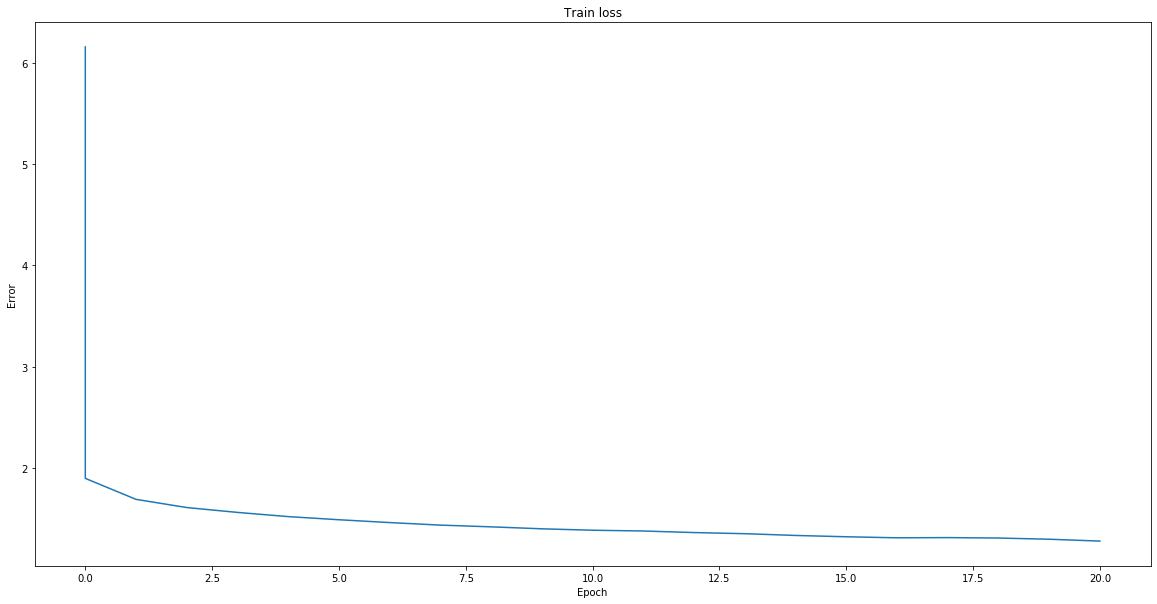

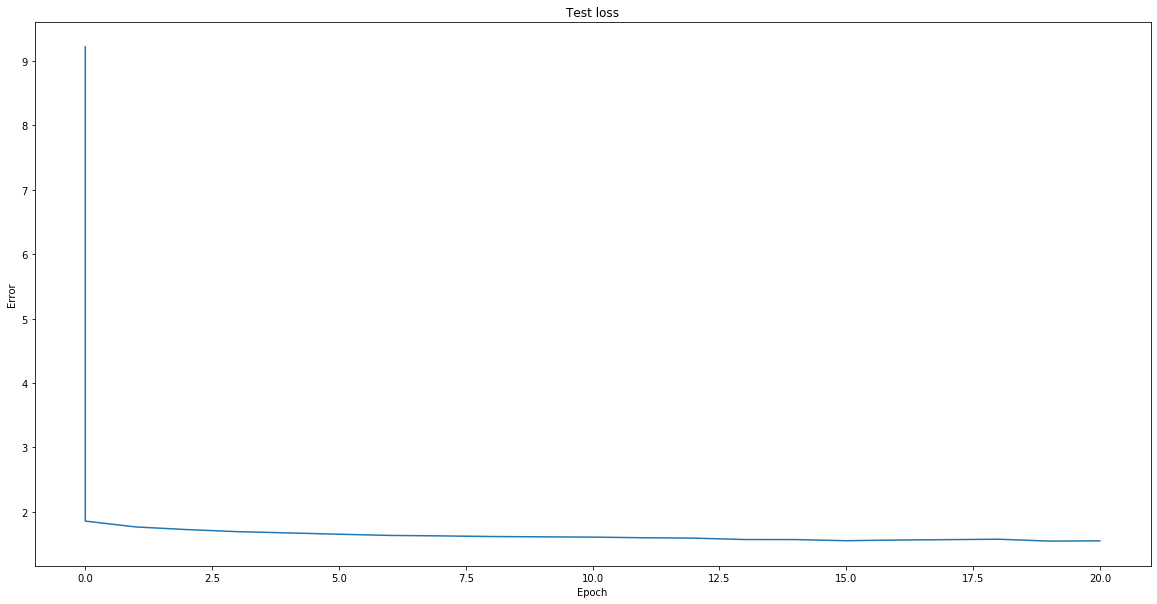

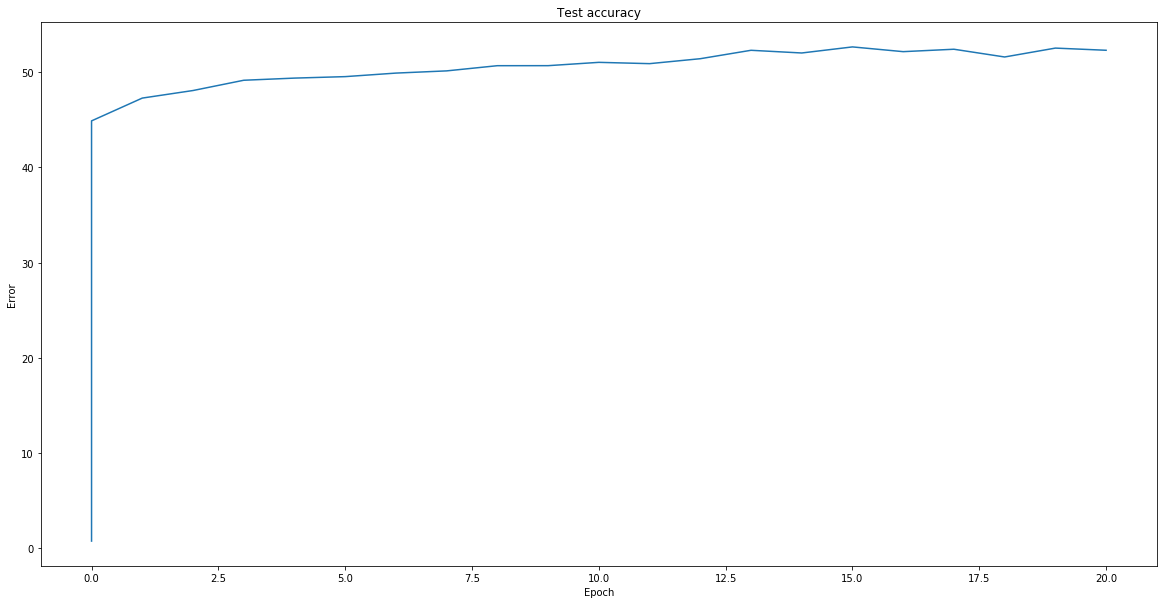

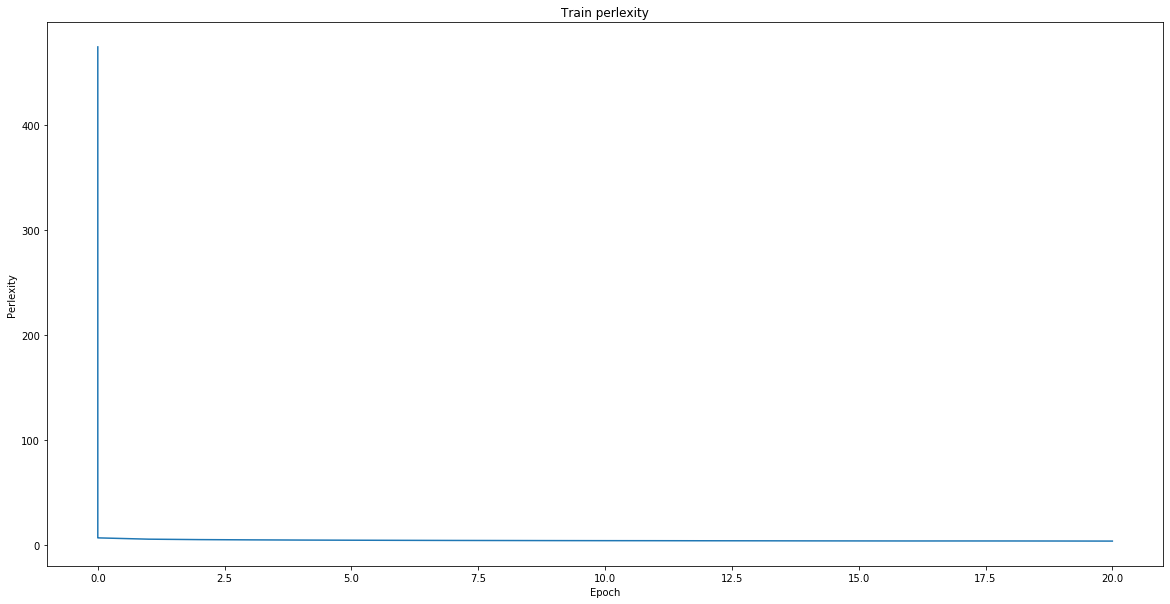

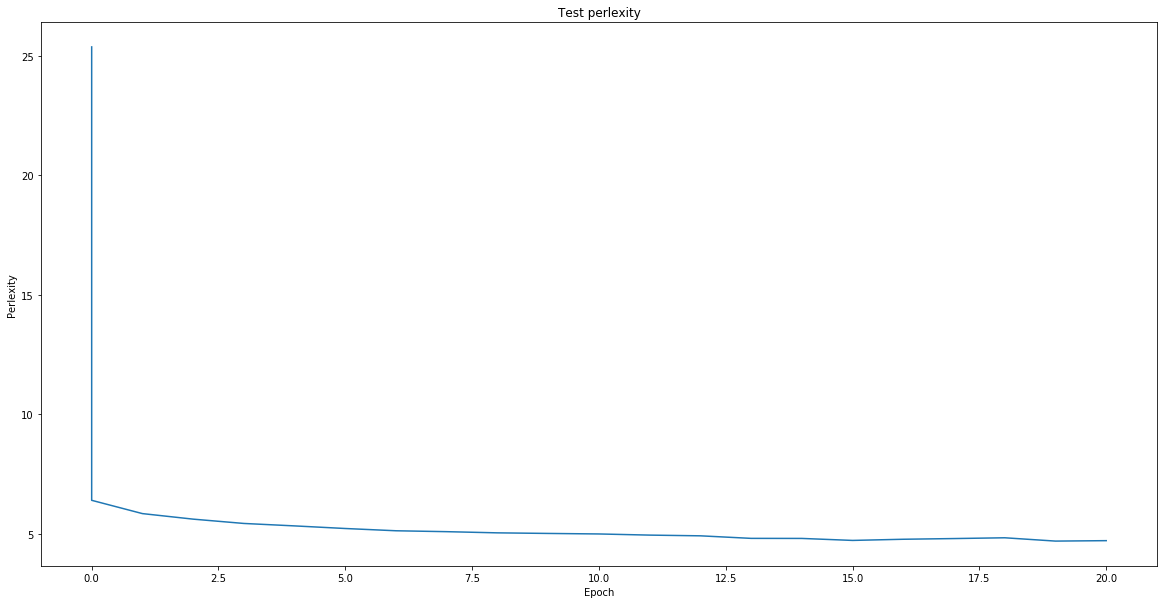

In [135]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_sea_lstm.pkl'


    data_train = LeagueUnderTheSeaDataset(DATA_PATH + 'Leagues_under_the_sea_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = LeagueUnderTheSeaDataset(DATA_PATH + 'Leagues_under_the_sea_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': 0,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LeageUnderTheSeaNet(data_train.vocab_size(), FEATURE_SIZE, device).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_sea_lstm')

    train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)#this is wrong
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):

            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            train_perlexity.append((epoch, np.exp(train_loss)))
            test_losses.append((epoch, test_loss))
            test_perlexity.append((epoch, np.exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perlexity, test_perlexity))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_sea_lstm/%03d.pt' % epoch, 3)
            seed_words = 'Will the waves one day carry to him this manuscript containing the history of his life?  Shall I ever know the name of this man?  Will the missing vessel '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_sea_lstm/%03d.pt' % epoch, 3)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perlexity)
        pt_util.plot(ep, val, 'Train perlexity', 'Epoch', 'Perlexity')
        ep, val = zip(*test_perlexity)
        pt_util.plot(ep, val, 'Test perlexity', 'Epoch', 'Perlexity')
        return model, vocab, device

final_model, vocab, device = main()

In [136]:
def eval_final_model(model, vocab, device):
    seed_words = 'The missing vessel and Captain Nemo '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 The missing vessel and Captain Nemo had not see no longer the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface of the surface o
generated with sample	 The missing vessel and Captain Nemo they-th, but; this monster, utter many  not micht he had alred a Germa whalers marine only."  I visilent light the contrary of mans accuon."  "What, inconsulted at is I is fancied by the misses wercis
generated with sample	 The missing vessel and Captain Nemo a nother.  "Ne no mosse yound his notess--I the Captain Nem has already day."  "I is all mergat, why the Island the sea was are issuily asked with gelass.  The morW disions of six Franchip which is el
generated with sample	 The missing vessel and Captain Nemo have them to have the oce, the 2rese nown admirad Lanchords."  "Dich externith, when impernance."  "Profess," resent all the shall you the narraves nom less the mos

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    